# Prediction Task:
## _Predict bike rental demand as a function of suitable features available in or derived from the data sets_

## Libraries and styles

In [1]:
# importing all relevant libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime, timedelta
from haversine import haversine, Unit

In [2]:
# set seaborn styles
sns.set()
sns.set_style("whitegrid")
sns.set_palette("rocket")

# set pandas display styles
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 2000)
pd.set_option('display.max_rows', 500)
%config IPCompleter.greedy=True

## Read data

In [3]:
def read_data(city_name):
    trip_data = pd.read_csv("Project_Data/Combined_Data/"+city_name+".csv", encoding = "ISO-8859-1")
    trip_data["trip_duration"] = pd.to_timedelta(trip_data["trip_duration"])
    trip_data["datetime_start"] = pd.to_datetime(trip_data["datetime_start"])
    trip_data["datetime_end"] = pd.to_datetime(trip_data["datetime_end"])
    trip_data["time"] = pd.to_datetime(trip_data["time"])
    trip_data["day"] = pd.to_datetime(trip_data["day"])
    return trip_data

In [4]:
dataBr = read_data("Bremen")
dataDu = read_data("Duesseldorf")

***
## Data for Prediction Task

### Prepare data
Since we have data sets with single entries (trips) at one specific point of time, it does not make sense to take a value from the single entries as a target (since there is no "rental demand" associated with a single trip). Rather, we have to group the trips by a time unit, e.g. hour or day, and aggregate the number of trips per time unit, so there is a target associated with our data that can be predicted.

In [5]:
dataBr.head()

,Unnamed: 0,day,time,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,...,fleetsize_weekly,fleetsize_dayly,fleetsize_monthly,distance,trip_duration_hours,avg_speed,rounded_time_hourly,temp,wind,rain
0,0,2019-04-21,2021-02-06 17:34:00,20507,bremen,00:13:00,53.078923,8.884911,53.078711,8.899906,...,331,163,395,1.001900,0.216667,4.624155,2019-04-21 18:00:00,20.4,2.0,0.0
1,1,2019-05-23,2021-02-06 15:33:00,20507,bremen,00:07:00,53.078923,8.884911,53.078004,8.876828,...,310,172,373,0.549476,0.116667,4.709793,2019-05-23 16:00:00,20.7,2.4,0.0
2,2,2019-06-14,2021-02-06 22:30:00,20507,bremen,00:08:00,53.078923,8.884911,53.074731,8.876003,...,304,204,342,0.755886,0.133333,5.669146,2019-06-14 22:00:00,19.6,4.4,0.0
3,3,2019-06-16,2021-02-06 10:00:00,20507,bremen,02:02:00,53.074731,8.876003,53.078923,8.884911,...,304,184,342,0.755886,2.033333,0.371747,2019-06-16 10:00:00,21.6,3.0,0.0
4,4,2019-06-16,2021-02-06 12:55:00,20507,bremen,02:23:00,53.078923,8.884911,53.076236,8.891322,...,304,184,342,0.522213,2.383333,0.219110,2019-06-16 13:00:00,21.8,4.4,0.0


#### add distance from city center

In [6]:
city1 = "Bremen"
city2 = "Duesseldorf"
start_date = "2019-02-01 00:00:00"
end_date = "2019-06-30 23:59:00"
startDate = datetime.fromisoformat(start_date)
endDate = datetime.fromisoformat(end_date)

In [7]:
# coordinates of city center as [lat, lng]
br_center = [53.078893247451994, 8.8027747491885]
du_center = [51.226815497281706, 6.773786392066722]

In [8]:
dataBr["distance_from_center_start"] = dataBr.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataBr["distance_from_center_end"] = dataBr.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(br_center[0], br_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_start"] = dataDu.apply(lambda row: haversine((row["orig_lat"], row["orig_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 
dataDu["distance_from_center_end"] = dataDu.apply(lambda row: haversine((row["dest_lat"], row["dest_lng"]),(du_center[0], du_center[1]),Unit.KILOMETERS), axis=1) 

#### Drop columns that are irrelevant for predicting hourly values
e.g. IDs

In [9]:
dBr = dataBr.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)
dDu = dataDu.drop(["Unnamed: 0","b_number","day","time","city","fleetsize_weekly","fleetsize_dayly","fleetsize_monthly"], axis=1)

#### main processing function

In [10]:
def process_data_for_city(data, city, start_date, end_date, group):
    '''
    Processes given data and aggregates certain columns per hour or day (group param) for a given city in a given time window
    
    :param data: the dataFrame of a given city
    :param city: a city in string format, e.g. "Bremen" or "Duesseldorf"
    :param start_date: an iso format time string, e.g. "2019-03-28 12:00:00"
    :param end_date: an iso format time string, e.g. "2019-03-31 12:00:00"
    :param group: a string, either "hour" or "day"
    '''

    # sorting of data
    dat = data.sort_values(by=['datetime_start'], axis=0)

    # select rows in the given time window
    dat_time_framed = dat.loc[(dat["datetime_start"] > startDate) & (dat["datetime_start"] <= endDate)]
    
    # Group data in the given time window by month, day and hours to get to specific hourly level
    # and aggregate on several columns
    times = pd.DatetimeIndex(dat_time_framed.datetime_start)
    grouping = [times.month, times.day, times.hour] if group == "hour" else  [times.month, times.day]
    dat_time_framed["inner"] = dat_time_framed["distance_from_center_start"] <= 1
    groupedBy = dat_time_framed.groupby(grouping).agg(trips_per_time=("datetime_start","count"), avg_temp=("temp","mean"), avg_wind=("wind","mean"), avg_rain=("rain","mean"), avg_distance=("distance","mean"), innerCityMean=("inner","mean"),avg_dist_from_center_start=("distance_from_center_start","mean"), avg_dist_from_center_end=("distance_from_center_end","mean"))
   
    # reset index to get the groupedBy values back as columns
    groupedBy.index.rename(["month", "day", "hour"] if group == "hour" else ["month","day"], inplace=True)
    groupedBy.reset_index(inplace=True)
    
    # generate string date column
    groupedBy["date"] = "2019-" + groupedBy["month"].astype(str) + "-" +  groupedBy["day"].astype(str) + " 00:00:00"

    # generate datetime column for checking of weekdays and remove string date column
    groupedBy["datetime"] = [pd.to_datetime(d) for d in groupedBy.date]
    groupedBy.drop(["date"], axis=1, inplace=True)

    # generate weekday column for later use
    groupedBy["weekday"] = [dt.weekday() for dt in groupedBy.datetime]
    groupedBy.drop(["datetime"], axis=1, inplace=True)

    # check, if date is weekday (.weekday() returns 0 for a monday, and 6 for a sunday)
    groupedBy["is_weekday"] = groupedBy["weekday"] <=4
    groupedBy.drop(["weekday"], axis=1, inplace=True)
    
    # function determining the peak time; col1 (weekdays) at rush hour time and col2(weekend) spread over the noon/afternoon
    def isPeaktime(col1, col2):
        if ( ((col1 == True) and (col2 in (5,6,7,8,15,16,17))) or ((col1 == False) and (col2 in (10,11,12,13,14,15,16)))):
            return True
        else: 
            return False
    
    # function determining dark hours; based on col1(hour)
    def isDark(col1):
        if col1 > 19 or col1 < 6:
            return True
        else: 
            return False
        
    # function determining rainy hours
    def isRainy(col1):
        if col1 > 0.3:
            return True
        else: 
            return False
        
    # function determining windy hours
    def isWindy(col1):
        if col1 >= 8:
            return True
        else: 
            return False
        
    groupedBy["is_peaktime"] = groupedBy.apply(lambda row: isPeaktime(row.is_weekday, row.hour), axis=1)
    groupedBy["is_dark"] = groupedBy.apply(lambda row: isDark(row.hour), axis=1)
    groupedBy["is_rainy"] = groupedBy.apply(lambda row: isRainy(row.avg_rain), axis=1)
    groupedBy["is_windy"] = groupedBy.apply(lambda row: isWindy(row.avg_wind), axis=1)
    
    return groupedBy

In [11]:
TIME_FRAME="hour"

#### prepared data:

In [12]:
br = process_data_for_city(dBr, city1, startDate, endDate, TIME_FRAME)
du = process_data_for_city(dDu, city2, startDate, endDate, TIME_FRAME) 

In [13]:
br.head()

,month,day,hour,trips_per_time,avg_temp,avg_wind,avg_rain,avg_distance,innerCityMean,avg_dist_from_center_start,avg_dist_from_center_end,is_weekday,is_peaktime,is_dark,is_rainy,is_windy
0,2,1,0,3,-1.900000,3.633333,0.0,1.951387,0.666667,1.055637,1.714003,True,False,True,False,False
1,2,1,1,1,-1.700000,3.300000,0.0,1.096250,1.000000,0.871499,0.224859,True,False,True,False,False
2,2,1,5,7,-1.200000,5.071429,0.0,1.323275,0.142857,3.424541,2.879705,True,True,True,False,False
3,2,1,6,12,-1.066667,5.500000,0.0,2.314619,0.416667,2.433299,2.542313,True,True,False,False,False
4,2,1,7,23,-0.717391,5.134783,0.0,1.910878,0.478261,1.511971,1.477329,True,True,False,False,False


***
## Correlation Analysis

The goal is to select those features (from the set of all features) that are optimally least correlated with each other and highly correlated with the target. We analyzed the correlation between features and the correlation of features with the target value. 

As a guideline one could take a boundary correlation value of 0.3 or -0.3 to detect low correlation between the features and take only those features into consideration for the prediction (see papers below).
However, some features with high correlation values between themselves still might be valuable for the prediction task, and a high correlation value might unnecessarily filter those out (e.g. rain probably has an impact on demand but might be highly correlated with temperature). For this reason, we observed the correlation between features themselves, but not necessarily used the inter-feature correlation as a justification for dropping or adding features.

We decided to consider features for the prediction task that show a correlation with the target above +-0.05 on two correlation metrics, or were selected through an algorithm, or are otherwise suspected to have an impact on demand. Note that some features were considered irrelevant (in part by using the boundary values of 0.3 and -0.3, as mentioned above) and thus dropped beforehand in the data preparation.

https://journals.sagepub.com/doi/pdf/10.1177/875647939000600106
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3576830/

### on unprepared data

#### Bremen

In [14]:
# showing the highest correlation values for a given data set with a given correlation metric
# disregards values equal to 1 at the diagonal
def show_high_corr(data, posMin, negMin, corr_method):
    corr = data.corr(method=corr_method)
    corr_val = np.array(corr)
    rows, cols = corr.shape
    flds = list(corr.columns)
    high_corr = []
    
    for i in range(cols):
        for j in range(i, cols):
            if corr_val[i,j] > posMin or corr_val[i,j] < negMin:
                if(i!=j):
                    high_corr.append([flds[i], flds[j], corr_val[i,j]])
    df = pd.DataFrame(high_corr, columns = ['col1', 'col2', 'correlation'])
    return df

In [15]:
# BREMEN, PEARSON CORRELATION
all_br_pe = show_high_corr(dBr, 0.3, -0.3, "pearson")
all_br_pe

,col1,col2,correlation
0,orig_lat,dest_lat,0.666620
1,orig_lng,dest_lng,0.642663
2,orig_lng,distance_from_center_start,0.519234
3,orig_lng,distance_from_center_end,0.333468
4,dest_lng,distance_from_center_start,0.333126
5,dest_lng,distance_from_center_end,0.521682
6,month,week,0.976644
7,month,temp,0.686158
8,week,temp,0.722585
9,distance,avg_speed,0.531795


In [16]:
# BREMEN, SPEARMAN CORRELATION
all_br_sp = show_high_corr(dBr, 0.3, -0.3, "spearman")
all_br_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.455863
1,orig_lng,dest_lng,0.516679
2,orig_lng,distance_from_center_start,0.557024
3,orig_lng,distance_from_center_end,0.316041
4,dest_lng,distance_from_center_start,0.317261
5,dest_lng,distance_from_center_end,0.567216
6,month,week,0.972424
7,month,temp,0.711116
8,week,temp,0.744299
9,distance,trip_duration_hours,0.591308


##### Bremen, unprepared data
- geo coordinates have a strong correlation with each other
- geo coordinates have a strong correlation with distance from city center
- distance from city center at trip start is highly correlated with distance from city center at trip end

**-->** remove geo coordinates or take only one out of those features with geo coordinates / distance from center, and only take one of the distances from city center

- month is highly correlated with week, temp, week is highly correlated with temp 

**-->** remove week

- distance is highly correlated with trip duration and average driving speed

**-->** remove trip duration and average driving speed

#### Düsseldorf

In [17]:
# DÜSSELDORF, PEARSON CORRELATION
all_du_pe = show_high_corr(dDu, 0.3, -0.3, "pearson")
all_du_pe

,col1,col2,correlation
0,orig_lat,dest_lat,0.720237
1,orig_lng,dest_lng,0.614139
2,orig_lng,distance_from_center_start,0.483375
3,orig_lng,distance_from_center_end,0.450291
4,dest_lng,distance_from_center_start,0.449899
5,dest_lng,distance_from_center_end,0.490173
6,month,week,0.965694
7,month,temp,0.617446
8,week,temp,0.672457
9,distance,avg_speed,0.440498


In [18]:
# DÜSSELDORF, SPEARMAN CORRELATION
results_du_sp = show_high_corr(dDu, 0.3, -0.3, "spearman")
results_du_sp

,col1,col2,correlation
0,orig_lat,dest_lat,0.625418
1,orig_lng,dest_lng,0.462044
2,orig_lng,distance_from_center_start,0.377244
3,dest_lng,distance_from_center_end,0.366026
4,month,week,0.901037
5,month,temp,0.660971
6,week,temp,0.710122
7,distance,trip_duration_hours,0.466940
8,distance,avg_speed,0.541234
9,trip_duration_hours,avg_speed,-0.351040


##### Düsseldorf, unprepared data
- similar to Bremen

### on prepared data

#### Bremen

In [19]:
# BREMEN, PEARSON CORRELATION
prep_br_pe = show_high_corr(br, 0.3, -0.3, "pearson")
prep_br_pe

,col1,col2,correlation
0,month,trips_per_time,0.338867
1,month,avg_temp,0.687527
2,trips_per_time,avg_temp,0.561897
3,trips_per_time,is_peaktime,0.410457
4,trips_per_time,is_dark,-0.535369
5,avg_wind,is_dark,-0.304448
6,avg_wind,is_windy,0.628055
7,avg_rain,is_rainy,0.752093
8,avg_distance,avg_dist_from_center_end,0.311460
9,innerCityMean,avg_dist_from_center_start,-0.490594


In [20]:
# BREMEN, SPEARMAN CORRELATION
prep_br_sp = show_high_corr(br, 0.3, -0.3, "spearman")
prep_br_sp

,col1,col2,correlation
0,month,trips_per_time,0.315185
1,month,avg_temp,0.697175
2,trips_per_time,avg_temp,0.542163
3,trips_per_time,is_peaktime,0.413714
4,trips_per_time,is_dark,-0.599289
5,avg_wind,is_dark,-0.331892
6,avg_wind,is_windy,0.434965
7,avg_rain,is_rainy,0.684100
8,innerCityMean,avg_dist_from_center_start,-0.521364
9,avg_dist_from_center_start,avg_dist_from_center_end,0.541276


##### Bremen, prepared data
- month is highly correlated with num of trips (**target**)
- num of trips (**target**) is highly correlated with average temp, peak time, ratio of trips in inner city, dark hours
- average temp is highly correlated with ratio of trips in inner city
- average wind is highly correlated with dark hours and windy (categorical variable)
- average rain is highly correlated with rainy (categorical variable)
- average driven distance is highly correlated with average distance from city center
- ratio of trips in inner city is highly correlated with average distance from city center
- peak time is highly correlated with dark hours

**-->** do not remove any from those for now, since they all seem valuable for the prediction (as they are assumed to have an impact on demand)

#### Düsseldorf

In [21]:
# DÜSSELDORF, PEARSON CORRELATION
prep_du_pe = show_high_corr(du, 0.3, -0.3, "pearson")
prep_du_pe

,col1,col2,correlation
0,month,trips_per_time,0.519501
1,month,avg_temp,0.608237
2,trips_per_time,avg_temp,0.679965
3,avg_wind,is_windy,0.595965
4,avg_rain,is_rainy,0.690253
5,avg_dist_from_center_start,avg_dist_from_center_end,0.920410
6,is_peaktime,is_dark,-0.364702


In [22]:
# DÜSSELDORF, SPEARMAN CORRELATION
prep_du_sp = show_high_corr(du, 0.3, -0.3, "spearman")
prep_du_sp

,col1,col2,correlation
0,month,trips_per_time,0.567465
1,month,avg_temp,0.633726
2,trips_per_time,avg_temp,0.671488
3,trips_per_time,innerCityMean,0.339376
4,trips_per_time,is_dark,-0.308852
5,avg_wind,is_dark,-0.318820
6,avg_wind,is_windy,0.345161
7,avg_rain,is_rainy,0.685355
8,innerCityMean,avg_dist_from_center_start,-0.461123
9,avg_dist_from_center_start,avg_dist_from_center_end,0.492323


##### Düsseldorf, prepared data
- no new findings

### correlation of features with target on prepared data set

#### Bremen

In [23]:
target_corr_br = pd.DataFrame(data=pd.DataFrame(data=br.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_br["spearman"] = pd.DataFrame(data=br.corr(method="spearman"))["trips_per_time"]
target_corr_br

,pearson,spearman
month,0.338867,0.315185
day,0.117279,0.119769
hour,0.217539,0.250862
trips_per_time,1.000000,1.000000
avg_temp,0.561897,0.542163
avg_wind,0.115841,0.180100
avg_rain,-0.079403,-0.089665
avg_distance,-0.016287,0.059868
innerCityMean,0.005871,0.108047
avg_dist_from_center_start,-0.002264,0.151340


#### Düsseldorf

In [24]:
target_corr_du = pd.DataFrame(data=pd.DataFrame(data=du.corr(method="pearson"))["trips_per_time"]).rename(columns={"trips_per_time": "pearson"})
target_corr_du["spearman"] = pd.DataFrame(data=du.corr(method="spearman"))["trips_per_time"]
target_corr_du

,pearson,spearman
month,0.519501,0.567465
day,0.164119,0.143165
hour,0.133344,0.124287
trips_per_time,1.000000,1.000000
avg_temp,0.679965,0.671488
avg_wind,0.007316,0.034251
avg_rain,-0.051334,-0.093836
avg_distance,-0.005307,0.110632
innerCityMean,0.001427,0.339376
avg_dist_from_center_start,-0.019572,0.146273


### Suitable features
#### those features from pepared data set with corr > 0.05 or < -0.05 and which are assumed to have impact on rental
- month
- hour
- day
- temp
- wind
- rain
- avg driven distance
- ratio of trips in the inner city
- avg distance from city center
- weekday
- peak time
- dark
- rainy 
- windy

***
# Prediction

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

### Feature selection
For this task, we select the Bremen data set as it seems more suitable, since it has more rows.

In [26]:
# all possible pre-selected features
allFeatures = ["month", "day", "hour", "avg_temp", "avg_wind", "avg_rain", "avg_distance", "avg_dist_from_center_end", "is_weekday", "innerCityMean", "is_peaktime", "is_dark", "is_rainy", "is_windy"]

#### via selectKBest algorithm

In [27]:
from sklearn.feature_selection import SelectKBest, f_regression

In [28]:
# Create and fit feature selector
selector = SelectKBest(f_regression, k=9)
selector.fit(br[allFeatures], br["trips_per_time"])
# Get selected columns
allFeatureDf = pd.DataFrame(columns=allFeatures)
cols = selector.get_support(indices=True)
allFeatureDf_best = allFeatureDf.iloc[:,cols]
print("Possibly best features:")
allFeatureDf_best.head()

Possibly best features:


,month,day,hour,avg_temp,avg_wind,avg_rain,is_weekday,is_peaktime,is_dark


#### via PCA:
confirm, how many features we need at minimum

In [29]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(br[allFeatures])
br_scaled = scaler.transform(br[allFeatures])
br_scaled_df = pd.DataFrame(br_scaled, columns = br[allFeatures].columns, index=br[allFeatures].index)

In [30]:
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
pca.fit_transform(br_scaled)
print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

[0.15441713 0.13363569 0.11919037 0.09681891 0.08343033 0.07452725
 0.07245517 0.06518439]
0.7996592502338191


In [31]:
pca2 = PCA(n_components=12)
pca2.fit_transform(br_scaled)
print(pca2.explained_variance_ratio_)
print(sum(pca2.explained_variance_ratio_))

[0.15441713 0.13363569 0.11919037 0.09681891 0.08343033 0.07452725
 0.07245517 0.06518439 0.06180126 0.04773843 0.03683983 0.02254436]
0.9685831265756338


**--> these results suggest that at least 11-12 features should be used. However, the prediction results suggested otherwise, because the performance is worse with 10 features or more, on all models across multiple metrics, except the boosting models**

### selected features for Prediction
Since the performance of almost all models was lower with 11-12 features than with 9, 
here we take 9 features yielding the best results (on models 3-7).

In [68]:
# SWITCH CITY HERE
city = "Bremen"
# city = "Düsseldorf"

if city == "Bremen":
    features = ["month", "day", "hour", "avg_temp", "avg_wind", "innerCityMean", "is_weekday", "is_peaktime", "is_dark"]
    X_full = br[features]
    y_full = br["trips_per_time"]
else:
    features = ["month", "day", "hour", "avg_temp", "avg_wind", "innerCityMean", "is_weekday", "is_peaktime", "is_dark"]
    X_full = du[features]
    y_full = du["trips_per_time"]

In [69]:
# selecting the recommended Train/Test Split of 70/30
SPLIT_TRAIN = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, random_state=0, train_size=SPLIT_TRAIN)

#### visualized target values, train and test

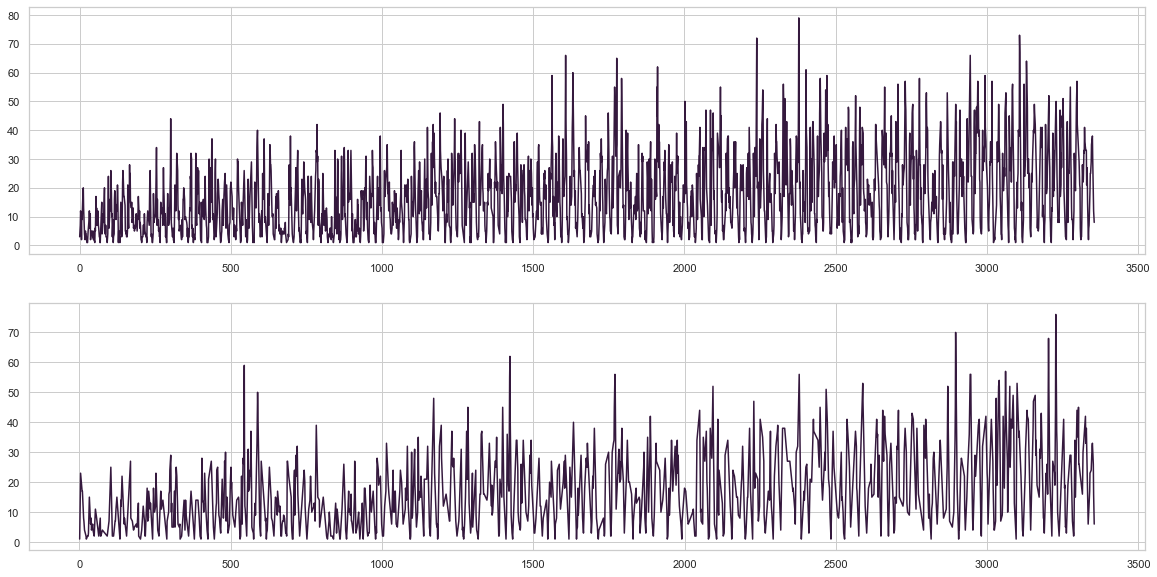

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
sns.lineplot(data=y_train, ax=ax1)
sns.lineplot(data=y_test, ax=ax2)

In [71]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor, GradientBoostingRegressor

## Model 1: Histogram Gradient Boosting regression
As we wanted to try out boosting techniques, here we use the histogram gradient boosting regressor from sklearn which promises better computation speed than gradient boosting regressor for larger data sets (n>10000)

In [72]:
## Histogram gradient Boosting
histgrad = HistGradientBoostingRegressor(max_iter=72).fit(X_train, y_train)

# prediction on test data
y_pred_histgrad = histgrad.predict(X_test)

# evaluate
r2_histgrad = r2_score(y_test, y_pred_histgrad)
MAE_histgrad =  mean_absolute_error(y_test, y_pred_histgrad)
MSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = True)
RMSE_histgrad = mean_squared_error(y_test, y_pred_histgrad, squared = False)

print (f'Histogram Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of histogram gradient boosting regression is: ', r2_histgrad)
print ('The MAE  of histogram gradient boosting regression is: ', MAE_histgrad)
print ('The MSE  of histogram gradient boosting regression is: ', MSE_histgrad)
print ('The RMSE of histogram gradient boosting regression is: ', RMSE_histgrad, "\n\n")

Histogram Gradient Boosting Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of histogram gradient boosting regression is:  0.7919581041275741
The MAE  of histogram gradient boosting regression is:  4.4253433580032935
The MSE  of histogram gradient boosting regression is:  37.356889022091444
The RMSE of histogram gradient boosting regression is:  6.112028224909587 




## Model 2: Gradient Boosting Regression
Here we use the standard gradient boosting regressor from sklearn.

In [73]:
## Gradient Boosting
grad = GradientBoostingRegressor(n_estimators=250, loss='ls').fit(X_train, y_train)

# prediction on test data
y_pred_grad  = grad.predict(X_test)

# evaluate
r2_grad = r2_score(y_test, y_pred_grad)
MAE_grad =  mean_absolute_error(y_test, y_pred_grad)
MSE_grad = mean_squared_error(y_test, y_pred_grad, squared = True)
RMSE_grad = mean_squared_error(y_test, y_pred_grad, squared = False)

print (f'Gradient Boosting Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of gradient boosting regression is: ', r2_grad)
print ('The MAE  of gradient boosting regression is: ', MAE_grad)
print ('The MSE  of gradient boosting regression is: ', MSE_grad)
print ('The RMSE of gradient boosting regression is: ', RMSE_grad)

Gradient Boosting Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of gradient boosting regression is:  0.7837571886111188
The MAE  of gradient boosting regression is:  4.486175220421679
The MSE  of gradient boosting regression is:  38.82948034579112
The RMSE of gradient boosting regression is:  6.231330543775632


In [74]:
def plot_results(predictions):
    fig, axes = plt.subplots(nrows=len(features), ncols=1, figsize=(15, 40))

    for i in range(0,len(features)):
        axes[i].scatter(X_train[features[i]],y_train, marker='x', color='b')
        axes[i].scatter(X_test[features[i]],predictions, marker='x', color='r')
        axes[i].set_xlabel(features[i])
        axes[i].set_ylabel("Demand")
        axes[i].legend(["Training Set", 'Prediction Set'])

## Model 3: Linear regression
The first "regular" model is a standard linear regression.

Linear Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of linear regression is:  0.5918838356269862
The MAE  of linear regression is:  6.621406827937593
The MSE  of linear regression is:  73.28307693347172
The RMSE of linear regression is:  8.560553541300452
Coefficients  [ 1.47020052  0.05977987  0.32719192  0.57354471 -0.07134118  2.36358565
  2.69881748  7.66668613 -8.61540822] 
Intercept  -1.1651039843135038


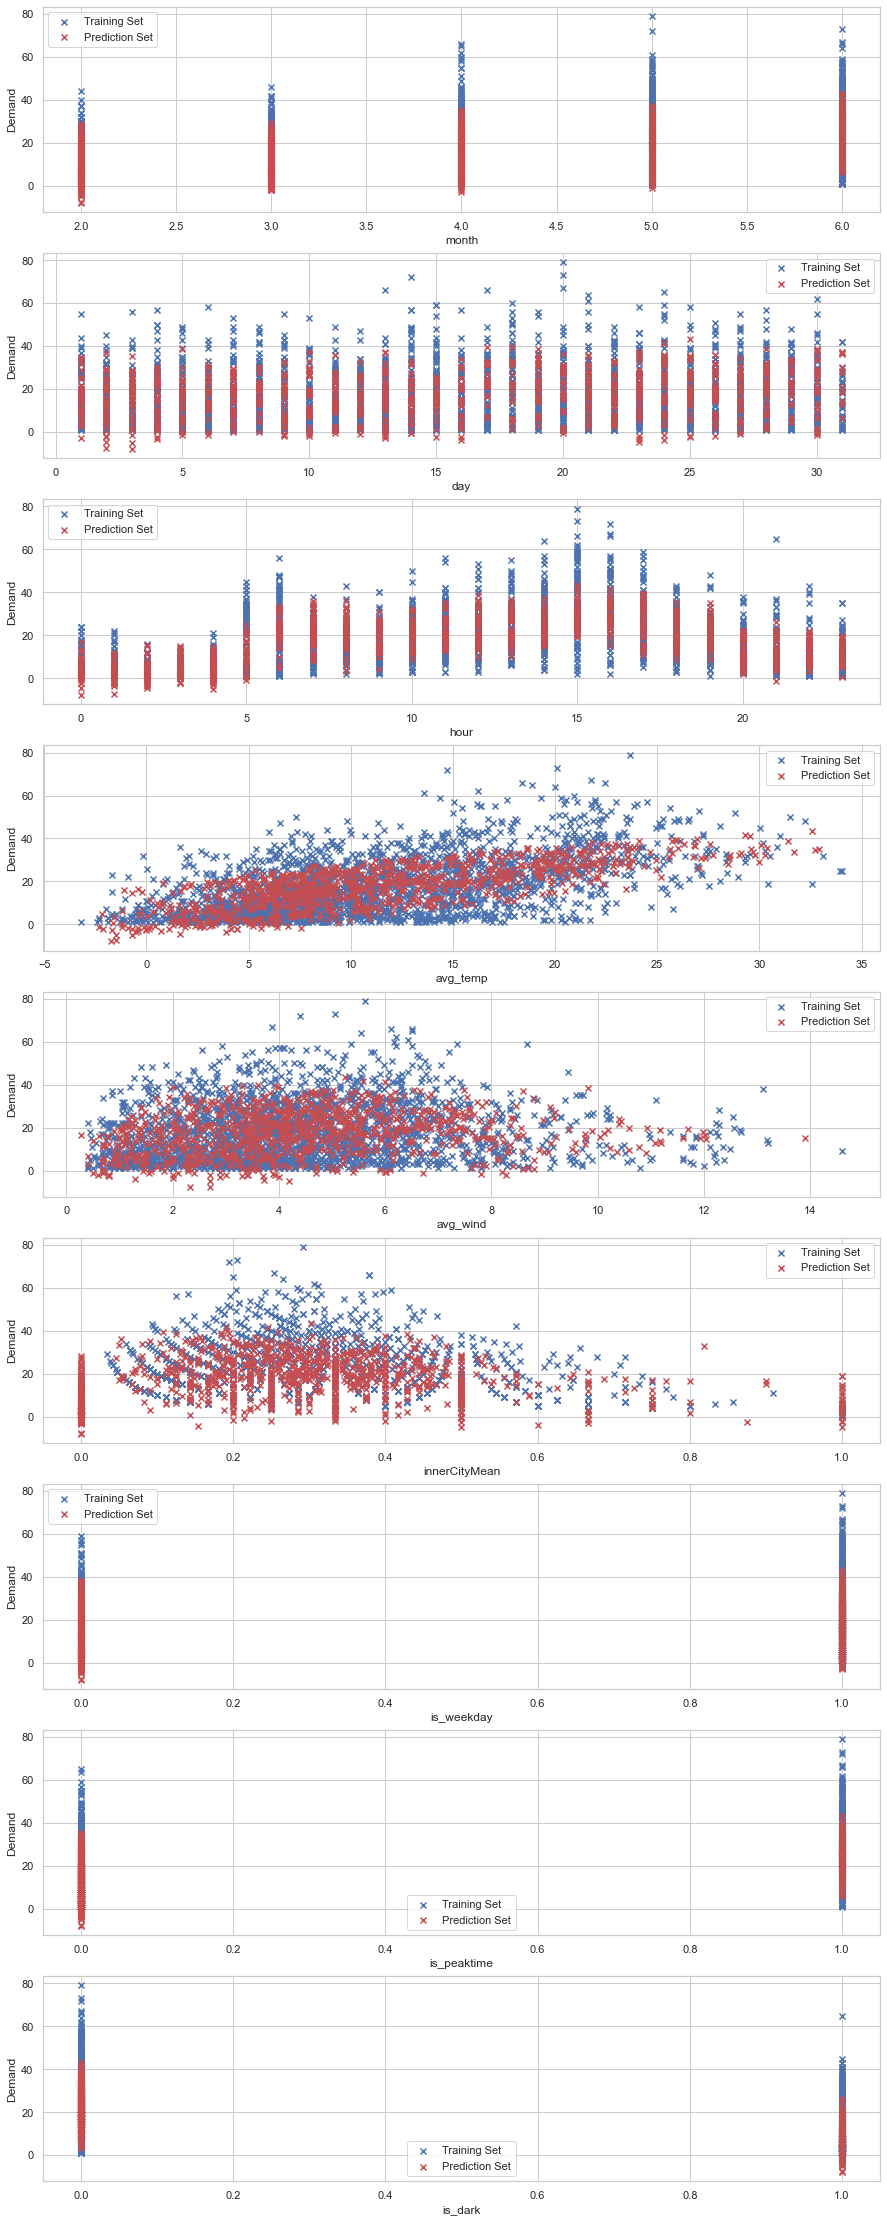

In [75]:
# fit model on training data
model_lin = LinearRegression(normalize = True)
model_lin.fit(X_train, y_train)

# prediction on test data
y_pred_lin = model_lin.predict(X_test)

# evaluate
r2_lin = r2_score(y_test, y_pred_lin)
MAE_lin =  mean_absolute_error(y_test, y_pred_lin)
MSE_lin = mean_squared_error(y_test, y_pred_lin, squared = True)
RMSE_lin = mean_squared_error(y_test, y_pred_lin, squared = False)

print (f'Linear Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of linear regression is: ', r2_lin)
print ('The MAE  of linear regression is: ', MAE_lin)
print ('The MSE  of linear regression is: ', MSE_lin)
print ('The RMSE of linear regression is: ', RMSE_lin)
print("Coefficients ", model_lin.coef_, "\nIntercept ", model_lin.intercept_ )
plot_results(y_pred_lin)

In [76]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

## Model 4: polynomial regression

Now, we try linear regression with polynomial features. We try to find the best possible polynomial degree via grid search and cross validation using gridSearchCV. The model with the best MAE is selected, to ensure compatibility we select all models that are validated with gridSearchCV by using the MAE. Note, that this might yield suboptimal r2 scores. However, we provide several metrics on each model (incl. r2 score) but only measure/search the best performing models by MAE for the sake of simplicity.

Regarding a good polynomial degree, we suspect that a degree below 3 is not able to capture the characteristics of the prepared data well. We can see some evidence to this in the graph Demand vs Hour from Model 3 (linear regression), where the curve of demand across hours 0-24 has a shape that would not be fitted well by linear or quadratic features.

### select best degree via grid search and cross validation

In [77]:
# using grid search to find best degree by MAE
param_grid = [
    {'poly__degree': [1, 2, 3, 4, 5]}
  ]
  
pipeline_poly = Pipeline(steps=[('poly', PolynomialFeatures()), ('linear', LinearRegression(normalize = True))])
Poly_GS = GridSearchCV(pipeline_poly, param_grid, cv=5,
                           scoring='neg_mean_absolute_error',
                           return_train_score=True)
Poly_GS.fit(np.array(X_train).reshape(y_train.shape[0],-1), y_train)

poly2 = PolynomialFeatures(degree = Poly_GS.best_params_["poly__degree"])
x_poly2 = poly2.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
PolyRegression = LinearRegression(normalize = True)
PolyRegression.fit(x_poly2, y_train)

LinearRegression(normalize=True)

### evaluate model

Polynomial Regression, hourly, degree: 3
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of polynomial regression is:  0.7348336536356928
The MAE  of polynomial regression is:  5.139793266309612
The MSE  of polynomial regression is:  47.61439868630715
The RMSE of polynomial regression is:  6.900318738022698
Coefficients  [-3.28603033e-12  1.17236235e+00  5.10151413e-02  3.86831887e+00
 -9.12693045e-01 -1.45334996e+00  1.70987376e+01 -5.74513852e+00
  2.82514211e+01  1.22114500e+01  2.02962709e+00 -3.45031509e-01
  1.19501947e-01 -1.43755371e-01 -5.58213948e-01  8.41014294e+00
 -4.13833236e-02 -4.21366813e-01 -2.02425907e+00  3.53967954e-02
 -5.27508329e-02  3.85362829e-02  1.10157379e-01  7.94786772e-01
 -3.85888125e-01 -1.58032630e-02  1.07047965e-01 -8.70447726e-03
  1.21481146e-01 -2.29192081e-02 -4.66299443e-01  1.49641591e+00
 -5.5818692

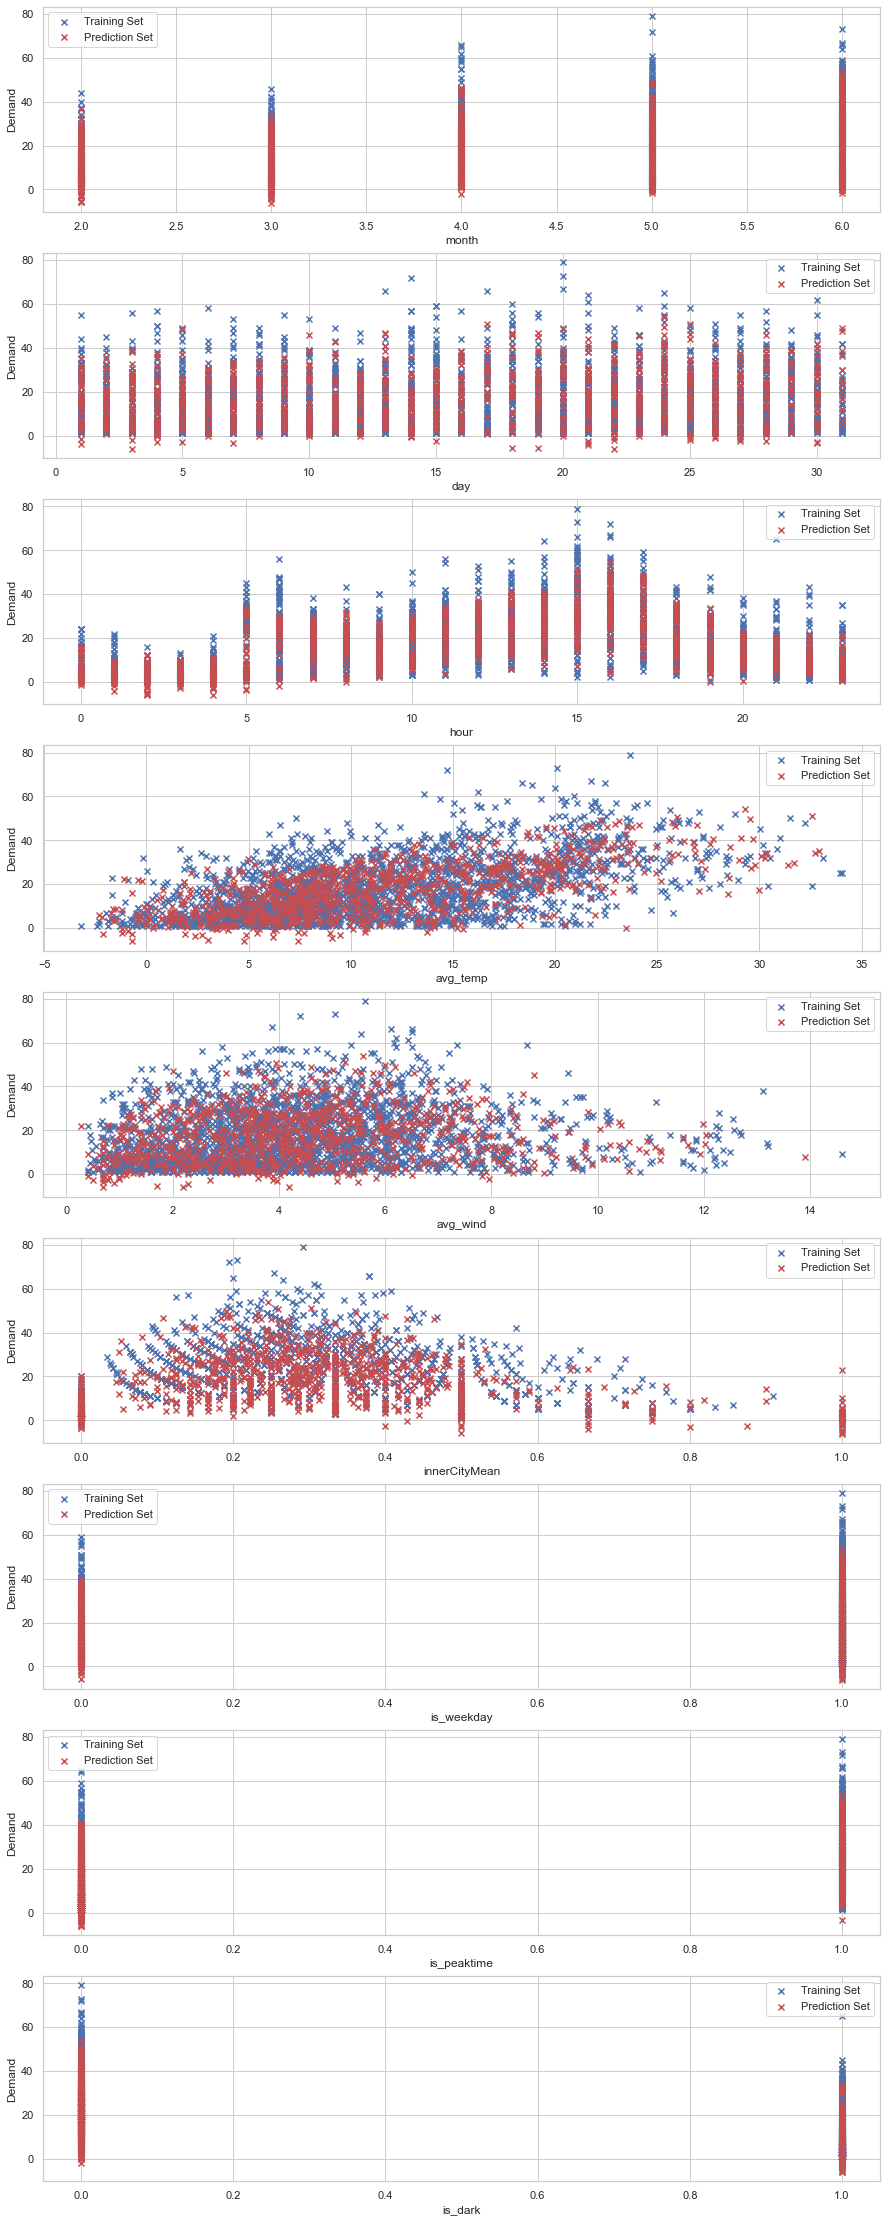

In [78]:
# prediction on test data
y_pred_poly = PolyRegression.predict(poly2.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_poly = r2_score(y_test, y_pred_poly)
MAE_poly =  mean_absolute_error(y_test, y_pred_poly)
MSE_poly = mean_squared_error(y_test, y_pred_poly, squared = True)
RMSE_poly = mean_squared_error(y_test, y_pred_poly, squared = False)

print (f'Polynomial Regression, {TIME_FRAME}ly, degree: {Poly_GS.best_params_["poly__degree"]}')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of polynomial regression is: ', r2_poly)
print ('The MAE  of polynomial regression is: ', MAE_poly)
print ('The MSE  of polynomial regression is: ', MSE_poly)
print ('The RMSE of polynomial regression is: ', RMSE_poly)
print("Coefficients ", PolyRegression.coef_, "\nIntercept ", PolyRegression.intercept_ )
plot_results(y_pred_poly)

## Model 5: Ridge regression

In [79]:
from sklearn.linear_model import Ridge

### select best params via grid search and cross validation
Since the best polynomial degree seems to be around 3, we now vary the degree around 3 with different regularization params

In [80]:
param_grid = {
    'poly__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    }

pipeline_ridge = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge(random_state=0, normalize = True))])

Ridge_GS = GridSearchCV(pipeline_ridge, param_grid, cv=5,
                           scoring='neg_mean_absolute_error')
Ridge_GS.fit(np.array(X_train).reshape(y_train.shape[0],-1), y_train)

# train model with best params on training set
poly_ridge = PolynomialFeatures(degree = Ridge_GS.best_params_["poly__degree"])
x_poly_ridge = poly_ridge.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
Ridgeregression = Ridge(**Ridge_GS.best_estimator_.named_steps['ridge'].get_params())
Ridgeregression.fit(x_poly_ridge,y_train)

Ridge(alpha=0.0001, normalize=True, random_state=0)

### evaluate model

Ridge Regression, hourly
Params:  {'poly__degree': 3, 'ridge__alpha': 0.0001}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of ridge regression is:  0.73393991392287
The MAE  of ridge regression is:  5.118972170114831
The MSE  of ridge regression is:  47.7748823962183
The RMSE of ridge regression is:  6.911937673056543
Coefficients  [ 0.00000000e+00  2.52436005e+00 -1.10867468e-01  1.45576702e+00
 -3.29498689e-01 -1.92477817e+00  1.72354782e+01 -4.29029001e+00
  1.88208391e+01  7.08531211e+00  4.02747307e-01 -1.93092842e-01
  2.17922395e-01 -9.53001326e-02  3.89952666e-02  7.74795873e+00
  2.13472277e-01  6.82037227e-01 -7.72798262e-01  2.89615346e-02
 -3.12494185e-02  8.52073717e-03  1.06724407e-01  6.62514462e-01
 -3.83256073e-01  8.67433772e-02  1.07095002e-01  7.50429095e-02
  8.66666190e-02  5.70145293e-02 -1.80698610e-01  1.28056479e+

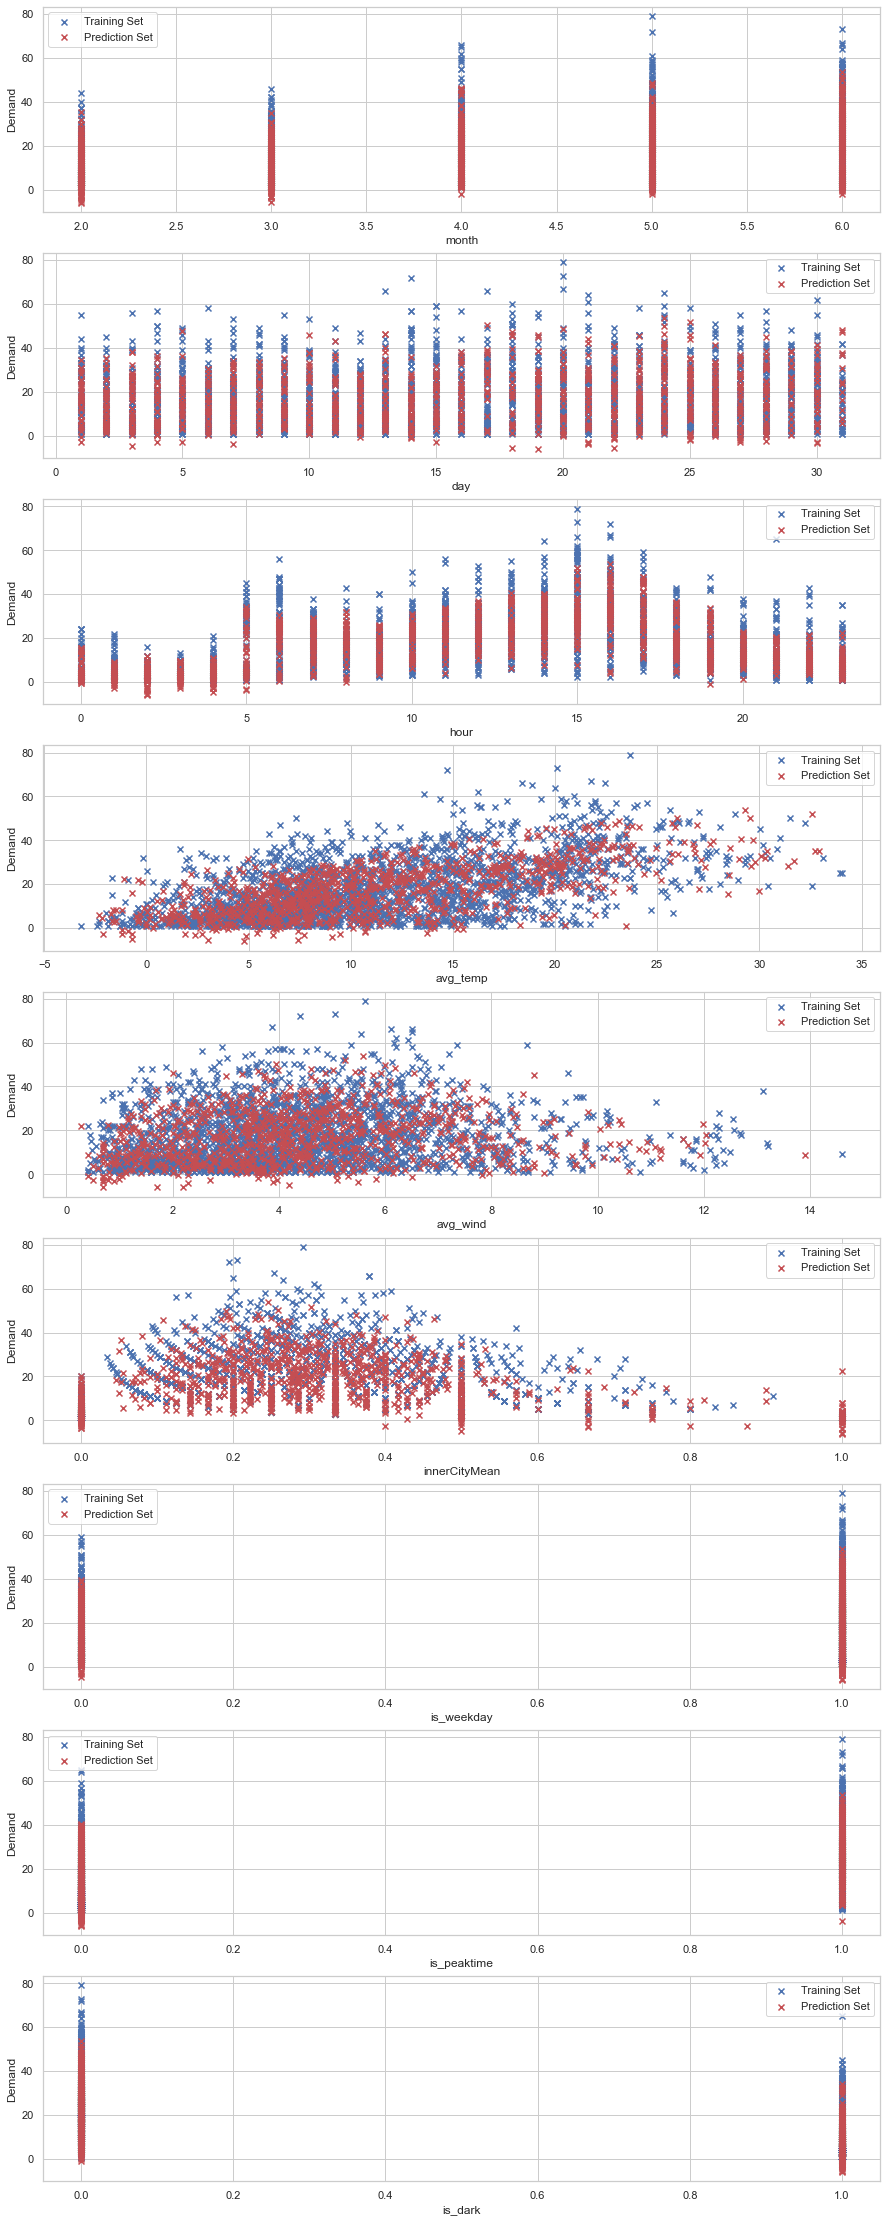

In [81]:
# prediction on test data
y_pred_ridge = Ridgeregression.predict(poly_ridge.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_ridge = r2_score(y_test, y_pred_ridge)
MAE_ridge =  mean_absolute_error(y_test, y_pred_ridge)
MSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = True)
RMSE_ridge = mean_squared_error(y_test, y_pred_ridge, squared = False)

print (f'Ridge Regression, {TIME_FRAME}ly')
print('Params: ', Ridge_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of ridge regression is: ', r2_ridge)
print ('The MAE  of ridge regression is: ', MAE_ridge)
print ('The MSE  of ridge regression is: ', MSE_ridge)
print ('The RMSE of ridge regression is: ', RMSE_ridge)
print("Coefficients ", Ridgeregression.coef_, "\nIntercept ", Ridgeregression.intercept_ )
plot_results(y_pred_ridge)

## Model 6: Lasso regression

In [82]:
from sklearn.linear_model import Lasso

### select best params via grid search and cross validation
Since the best polynomial degree seems to be around 3, we now vary the degree around 3 with different regularization params

In [83]:
param_grid = {
    'poly__degree': [3, 4, 5, 6],
    'lasso__alpha': [1, 0.1, 0.01, 0.001, 0.0001],
    }

pipeline_lasso = Pipeline(steps=[('poly', PolynomialFeatures()), ('lasso', Lasso(random_state=0, normalize = True))])

Lasso_GS = GridSearchCV(pipeline_lasso, param_grid, cv=5,
                           scoring='neg_mean_absolute_error')
Lasso_GS.fit(np.array(X_train).reshape(y_train.shape[0],-1), y_train)

# train model with best params on training set
poly_lasso = PolynomialFeatures(degree = Lasso_GS.best_params_["poly__degree"])
x_poly_lasso = poly_lasso.fit_transform(np.array(X_train).reshape(y_train.shape[0],-1))
Lassoregression = Lasso(**Lasso_GS.best_estimator_.named_steps['lasso'].get_params())
Lassoregression.fit(x_poly_lasso,y_train)

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 141.94438960481784, tolerance: 32.541387014369356
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 116.98151452816091, tolerance: 32.46600276742945
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 153.51343016396277, tolerance: 33.13787982969664
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19339.247233064063, tolerance: 33.30080425531916
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19541.168162521986, tolerance: 32.541387014369356
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18257.396986754895, tolerance: 32.46600276742945
  model = cd_fast.enet_coordinate_descent(
C:\Users\andre\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWa

Lasso(alpha=0.0001, normalize=True, random_state=0)

### evaluate model

Lasso Regression, hourly
Params:  {'lasso__alpha': 0.0001, 'poly__degree': 4}
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of lasso regression is:  0.7384665415704121
The MAE  of lasso regression is:  4.9873865945221905
The MSE  of lasso regression is:  46.962061853680765
The RMSE of lasso regression is:  6.852887118118959
Coefficients  [ 0.00000000e+00  9.35543687e-01 -0.00000000e+00  1.29535849e+00
  2.35460133e-02  0.00000000e+00  8.22783814e+00 -0.00000000e+00
  1.13795043e+01  0.00000000e+00  8.32642456e-02 -1.76074896e-02
  2.02200538e-01  0.00000000e+00  8.38749206e-03  4.95434199e+00
  0.00000000e+00  6.22292502e-01 -0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  4.64187599e-03  5.75570849e-02
 -1.28285959e-01  0.00000000e+00  0.00000000e+00  1.29483850e-02
  3.49487313e-02  0.00000000e+00  0.00000000e+00  0.00000

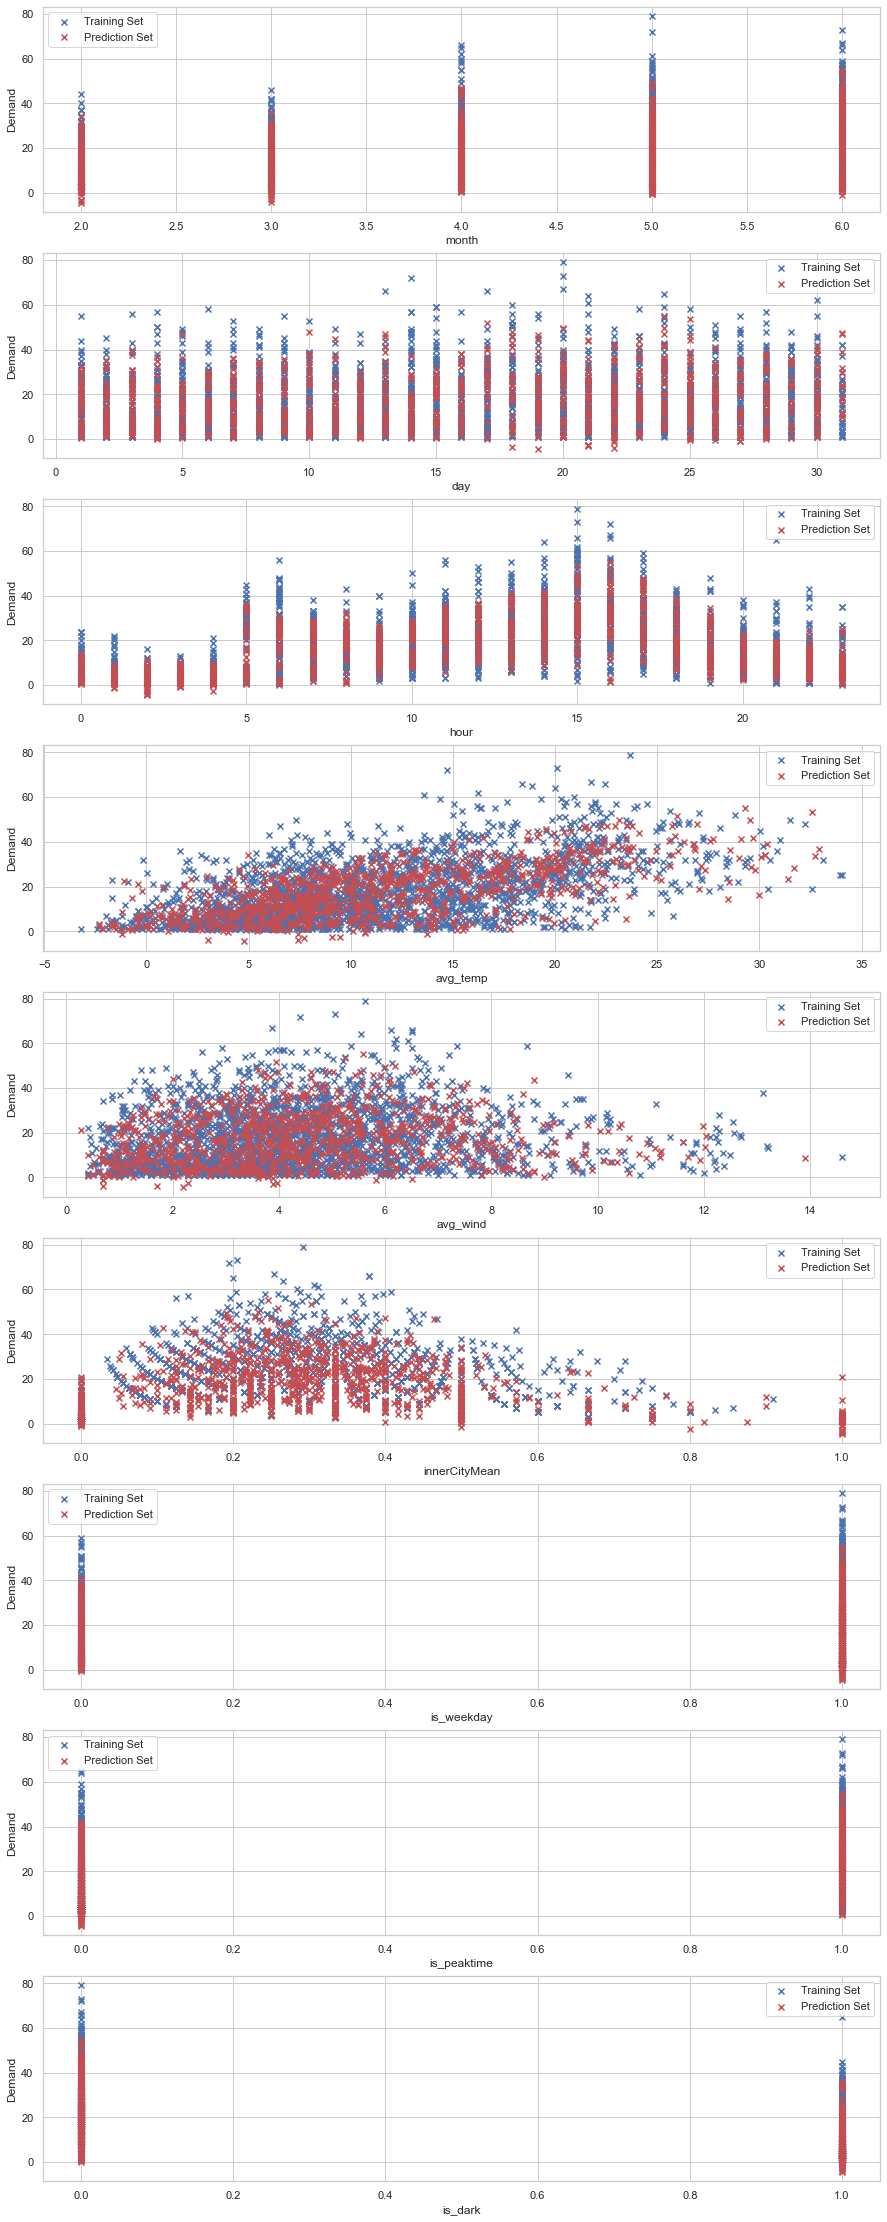

In [84]:
# prediction on test data
y_pred_lasso = Lassoregression.predict(poly_lasso.fit_transform(np.array(X_test).reshape(y_test.shape[0],-1)))

# evaluate
r2_lasso = r2_score(y_test, y_pred_lasso)
MAE_lasso=  mean_absolute_error(y_test, y_pred_lasso)
MSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = True)
RMSE_lasso = mean_squared_error(y_test, y_pred_lasso, squared = False)

print (f'Lasso Regression, {TIME_FRAME}ly')
print('Params: ', Lasso_GS.best_params_)
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of lasso regression is: ', r2_lasso)
print ('The MAE  of lasso regression is: ', MAE_lasso)
print ('The MSE  of lasso regression is: ', MSE_lasso)
print ('The RMSE of lasso regression is: ', RMSE_lasso)
print("Coefficients ", Lassoregression.coef_, "\nIntercept ", Lassoregression.intercept_ )
plot_results(y_pred_lasso)

## Model 7: Random Forest Regression

In [85]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor(max_depth=2, random_state=0)
reg_rf.fit(X_train, y_train)

# prediction on test data
y_pred_reg_rf = reg_rf.predict(X_test)

# evaluate
r2_reg_rf = r2_score(y_test, y_pred_reg_rf)
MAE_reg_rf =  mean_absolute_error(y_test, y_pred_reg_rf)
MSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = True)
RMSE_reg_rf = mean_squared_error(y_test, y_pred_reg_rf, squared = False)

print (f'Random Forest Regression, {TIME_FRAME}ly')
print ("Training splits: Training set ", SPLIT_TRAIN, ", Test set: ",1-SPLIT_TRAIN)
print ("Features: ", features)
print ('The R^2  of Random Forest regression is: ', r2_reg_rf)
print ('The MAE  of Random Forest regression is: ', MAE_reg_rf)
print ('The MSE  of Random Forest regression is: ', MSE_reg_rf)
print ('The RMSE of Random Forest regression is: ', RMSE_reg_rf)


Random Forest Regression, hourly
Training splits: Training set  0.7 , Test set:  0.30000000000000004
Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']
The R^2  of Random Forest regression is:  0.5129406926178328
The MAE  of Random Forest regression is:  7.077967463004057
The MSE  of Random Forest regression is:  87.45844396750628
The RMSE of Random Forest regression is:  9.351921939767584


***
# Results for hourly demand prediction, Bremen

## Three Best Prediction models:
### Histogram Gradient Boosting regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of histogram gradient boosting regression is:  0.7919581041275741
- The MAE  of histogram gradient boosting regression is:  4.4253433580032935
- The MSE  of histogram gradient boosting regression is:  37.356889022091444
- The RMSE of histogram gradient boosting regression is:  6.112028224909587 

### Gradient Boosting regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of gradient boosting regression is:  0.7837825446192317
- The MAE  of gradient boosting regression is:  4.4845545737530585
- The MSE  of gradient boosting regression is:  38.824927312964974
- The RMSE of gradient boosting regression is:  6.230965199145713

### Lasso Regression
- Params:  {'lasso__alpha': 0.0001, 'poly__degree': 4}
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of lasso regression is:  0.7384665415704121
- The MAE  of lasso regression is:  4.9873865945221905
- The MSE  of lasso regression is:  46.962061853680765
- The RMSE of lasso regression is:  6.852887118118959

***
# Results for hourly demand prediction, Düsseldorf

## Three Best Prediction models:
### Gradient Boosting regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of gradient boosting regression is:  0.7597016620731614
- The MAE  of gradient boosting regression is:  2.632095232427055
- The MSE  of gradient boosting regression is:  17.881193164619084
- The RMSE of gradient boosting regression is:  4.228615986894422

### Histogram Gradient Boosting regression
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of histogram gradient boosting regression is:  0.756687610329741
- The MAE  of histogram gradient boosting regression is:  2.642236247566803
- The MSE  of histogram gradient boosting regression is:  18.105476203350154
- The RMSE of histogram gradient boosting regression is:  4.255053020039839 

### Lasso Regression
- Params:  {'lasso__alpha': 0.001, 'poly__degree': 6}
- Training splits: Training set  0.7 , Test set:  0.30000000000000004
- Features:  ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark']


- The R^2  of lasso regression is:  0.725571149826834
- The MAE  of lasso regression is:  2.982267737574925
- The MSE  of lasso regression is:  20.42092892621136
- The RMSE of lasso regression is:  4.51895219339742

## General explanation of results, exemplary for Bremen
The best prediction model, using histogram gradient boosting regression, yielded an r^2 score of roughly 79,19%, which means that the model could explain or predict about 3/4 of the provided data and its variance. The Mean Absolute Error of 4.42 Units indicates that the model could predict hourly bike rental demand with a mean deviation of +- 4.42 rentals. The MSE of 37.35 Units and RMSE of 6.11 Units indicate that there are some higher deviations of predicted rental demand when compared to the MAE of 4.42. Higher deviations are obviously undesirable, but due to the highly variable nature of bike rental demand we assume the model performance to be bound by the provided data, which also contains high deviations.

## Implications
As the correlation analysis and prediction results suggest, we found evidence for some fairly obvious, but mostly anecdotal statements:
- The bike rental demand rises as the temperature increases, which can be observed when summer months are approached
- The hour of day matters for predicting the demand, since there are peak rental times (morning and afternoon hours), as well as lower rental demand in dark/night hours
- The weather is highly influencing bike rental demand, with rain and wind reducing the number of rented bikes
- The number of bike rentals is higher in the inner city
- The bike rental demand varies between weekdays and weekends
- The bike rental demand varies strongly between cities, especially the aforementiond effects (e.g. impact of temperature on demand) vary between the cities

The features from model 3 (linear regression) ['month', 'day', 'hour', 'avg_temp', 'avg_wind', 'innerCityMean', 'is_weekday', 'is_peaktime', 'is_dark'] from Bremen are weighted with the coefficients [ 1.47020052  0.05977987  0.32719192  0.57354471 -0.07134118  2.36358565   2.69881748  7.66668613 -8.61540822], which means that the day, hour and average temperature have a low positive impact (+ 0.05 - 0.6 units of demand per added feature unit) on rental demand, the ratio of trips in inner city and weekday have a medium positive impact (+ 2 - 3 units of demand per added feature unit). The feature is_peaktime has a strong positive impact on rental demand (+ 7.6 units of demand per added feature unit). The average wind (unit: m/s) has a low negative impact on rental demand (- 0.07 units of demand per added feature unit), while the feature is_dark has a strong negative impact (- 8.6 units of demand per added feature unit) on rental demand.


Based on this evidence, nextBike can optimize its service, especially the size of operating fleet, by incorporating said factors into their calculations. That could mean they set up a higher number of stations in the inner city, or try to increase their fleet size dramatically when the summer months are approaching. Another approach could be to react on weather forecast, because a drought could be accompanied by increased rental demand. Also the variance of demand between distinct hours of day and between weekdays and weekends open up opportunities to adjust their fleet dynamically, reducing the operation cost to the minimum.

## Possible Improvement 
The most important and promising improvement lever for future projects is a more detailed and dedicated selection of features. The comparison with hourly prediction suggests that a thorough analysis of weather data resulting in categorical weather features could yield even better results.

Another improvement lever could be the usage of holiday, event and natural event data, e.g. national holidays or soccer games to reduce the daily variance or to better predict high deviations from the mean demand.